In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from tqdm import tqdm
from matplotlib import cm

from iteration_utilities import flatten
# import ipyparams
from helper_functions import propagate_deflected_muons_custom, get_angle_deviation, energy_name, get_zenith_deflections_along_track, save_data_along_dict, load_data_along_dict

In [2]:
save_plot = True

# currentNotebook = ipyparams.notebook_name[:len(ipyparams.notebook_name)-6] # get name of currect notebook
# assert currentNotebook != '', "no notebook name, run cell again"

currentNotebook = "deflection_along_sampling"

plot_dir = 'plots/{}/'.format(currentNotebook)
os.system('mkdir -p {}'.format(plot_dir))

df_dir = 'data/{}/'.format(currentNotebook)
os.system('mkdir -p {}'.format(df_dir))


colors = {
    'brems': cm.tab10(0),
    'nuclint': cm.tab10(1), 
    'epair': cm.tab10(2),
    'ioniz': cm.tab10(3) 
}

In [3]:
cm.tab10

In [4]:
n_events = 1000
E_i = 1e9 # 1 PeV (corresponds to MeV)
E_f = 1e6 # 1 TeV (corresponds to MeV)
E_i_final = np.ones(n_events) * E_i
E_f_final = np.ones(n_events) * E_f

interpol_nodes = 200
scattering_method =  "moliere" # "highland"

e_cut = 500 # np.inf
v_cut = 0.05 # 1e-5

set_name = "{}_{}_{}events_{}_ecut{}_vcut{}_interpol{}".format(energy_name(E_i), energy_name(E_f), n_events, scattering_method, e_cut, v_cut, interpol_nodes)
print(set_name)

# table_path="/Users/pascalgutjahr/.cache/PROPOSAL" # lehrstuhl macbook
table_path="/net/nfshome/home/pgutjahr/.cache/PROPOSAL" # vollmond

hdf_name = 'df_{}_{}_{}events.hdf'.format(energy_name(E_i), energy_name(E_f), n_events)
hdf_name

1PeV_1TeV_1000events_moliere_ecut500_vcut0.05_interpol200


'df_1PeV_1TeV_1000events.hdf'

# Sample deflections along extern using energies of propagation

## Check energies!! GeV or MeV?!

In [5]:
### deflection parametrizations

# ------- bremsstrahlung --------
### Van Ginneken
def get_brems_rms_theta_vG_final(E, E_, Z=82, m=0.10566):
    nu = (E - E_) / (E - m)
    if nu <= 0.5:
        k_1 = 0.092 * E**(-1/3)
        k_2 = 0.052 / E * Z**(-1/4)
        k_3 = 0.22 * E**(-0.92)
        rms_theta = np.max([np.min([k_1 * np.sqrt(nu), k_2]), k_3 * nu])
        return rms_theta
    if nu > 0.5:
        k_4 = 0.26 * E**(-0.91)
        m = 0.5
        d = 1.8
        n = 0.81 * E**m / (E**m + d)
        rms_theta = k_4 * nu**(1+n) * (1 - nu)**(-n)
        if rms_theta < 0.2:
            return rms_theta
    if nu > 0.5:
        # k_5 = k_4 * nu**(1+n) * (1-nu)**(0.5-n)
        ###
        # x_min = 5e-5 # 5e-3
        # v = np.logspace(np.log10(x_min), np.log10(0.5), int(1e6))
        # nu_lin = 1 - v 
        # nu_g = nu_lin[np.argmin(abs(f_nu_g(nu_lin, f_n(E), f_k_4(E))))]
        ###
        nu_g = get_nu_g(E)
        ### nu_g = get_nu_g_1(E) # no relevant speed difference
        k_5 = k_4 * nu_g**(1+n) * (1-nu_g)**(0.5-n)
        rms_theta = k_5 * (1 - nu)**(-0.5)
        if rms_theta >= 0.2:
            return rms_theta
    else:
        assert False, 'nu_g = {}'.format(nu_g)
        
def f_nu_g(nu_g, n, k_4):
    return (nu_g**(1/n + 1) + (0.2/k_4)**(1/n) * nu_g - (0.2/k_4)**(1/n))

def f_n(E, m=0.5, d=1.8):
    return 0.81 * E**m / (E**m + d)

def f_k_4(E):
    return 0.26 * E**(-0.91)

def get_nu_g(E, x_min=5e-5):
    v = np.logspace(np.log10(x_min), np.log10(0.5), int(1e6))
    nu_lin = 1 - v 
    nu_g = nu_lin[np.argmin(abs(f_nu_g(nu_lin, f_n(E), f_k_4(E))))]
    return nu_g

def get_nu_g_1(E, x_min=5e-5):
    v = np.logspace(np.log10(x_min), np.log10(0.5), int(1e6))
    nu_lin = 1 - v 
    n = 0.81 * E**0.5 / (E**0.5 + 1.8)
    k_4 = 0.26 * E**(-0.91)
    nu_g = nu_lin[np.argmin(abs(f_nu_g(nu_lin, n, k_4)))]
    return nu_g

# sample from van Ginneken
def get_brems_theta_vG(E, E_, rnd_state, Z=1, is_degree=True):
    rms_theta = get_brems_rms_theta_vG_final(E, E_, Z=Z)
    theta_muon = np.sqrt(rnd_state.exponential(rms_theta**2))
    if is_degree:
        return np.rad2deg(theta_muon)
    else:
        return theta_muon

### Geant4 sampling 
def get_new_psi_brems(E, E_, rnd_state, is_degree=True, theta_star=1):
    epsilon = E - E_
    mu = 0.1057  # muon mass
    p = rnd_state.uniform(0, 1)
    r_max = np.minimum(1, E_/epsilon) * E * theta_star / mu
    a = p * r_max**2 / (1+r_max**2)
    r = np.sqrt(a/(1-a))
    theta_photon = mu / E * r
    theta_mu = epsilon / E_ * theta_photon
    
    if is_degree:
        return np.rad2deg(theta_mu)
    else:
        return theta_mu
    
# ----------- nuclint ----------
def get_new_psi_nuclint(E, E_, rnd_state, is_degree=True, nu_min=None, nu_max=True):
    M = 0.9383 # Proton mass
    mu = 0.1057 # Muon mass
    if nu_min is not None:
        if E - E_ < nu_min:
            print('minimum energy transfer is 0.2 GeV')
            return 0
    if nu_max:
        nu_max = E - M / 2
        if E - E_ > nu_max:
            print('maximum energy transfer is (E - mass_nucleon/2)={}, but here: ', E - E_)
            return 0
    m_0=np.sqrt(0.4)
    p = rnd_state.uniform(0, 1)
    # nu = epsilon
    epsilon = E - E_
    y = epsilon / E
    t_max = 2 * M * epsilon
    t_min = (mu * y)**2 / (1 - y)
    t_1 = np.minimum(epsilon**2, m_0**2)
    t_p = (t_max * t_1) / ((t_max + t_1) * ((t_max * (t_min + t_1))\
                    / (t_min * (t_max + t_1)))**p - t_max)
    sin2 = (t_p - t_min) / (4 * (E * E_ - mu**2) - 2 * t_min)
    theta_mu = 2 * np.arcsin(np.sqrt(sin2))
    
    if is_degree:
        return np.rad2deg(theta_mu)
    else:
        return theta_mu
    
def get_new_psi_nuclint_ginneken(E, E_, rnd_state, m=0.1057, is_degree=True):
    nu = (E - E_) / (E - m)
    rms_theta = (0.39 / (E * (1 - nu))) * (np.sqrt(E) * nu * (1 - nu))**0.17 * (1 - 0.135/(E * nu))
    theta_mu = np.sqrt(rnd_state.exponential(rms_theta**2))
    if is_degree:
        return np.rad2deg(theta_mu)
    else: return theta_mu  
    
# -------- epair ------------
def get_new_psi_pairprod_exp(E, E_, rnd_state, is_degree=True):
    n = -1
    a = 8.9e-4
    b = 1.5e-5
    c = 0.032
    d = 1
    e = 0.1
    m = 105.7 / 1e3 # in GeV
    m_e =   0.5110 / 1e3 # in GeV
    nu = (E - E_) / (E - m)
    minimum = np.min([a * nu**(1/4) * (1 + b*E) + c * nu / (nu + d), e])
    rms_theta = (2.3 + np.log(E)) * (1- nu)**n / E * (nu - 2 * m_e/E)**2 / nu**2 * minimum
    # theta = abs(rnd_state.normal(0, rms_theta/np.sqrt(2), 1)[0])
    # theta = rnd_state.normal(rms_theta**2, rms_theta, 1)[0]
    theta_muon = np.sqrt(rnd_state.exponential(rms_theta**2))
    # theta_real = abs(theta - rms_theta**2)
    if is_degree:
        return np.rad2deg(theta_muon)
    else:
        return theta_muon
    
    
# --------- ioniz ----------
def get_new_psi_deltaE_NEW(E_mu, E_mu_prime, m_e=0.000511, m_mu=0.105658, is_degree=True):
    # m_e = 0.511
    # m_mu = 105.658
    assert E_mu > m_mu, 'incoming energy lower than muon mass'
    
    gamma = E_mu / m_mu
    epsilon_max = 2 * m_e * (gamma**2 - 1) / (1 + 2*gamma*m_e/m_mu + (m_e/m_mu)**2) 
    assert E_mu_prime > E_mu - epsilon_max
    
    p_mu = np.sqrt((E_mu + m_mu) * (E_mu - m_mu))
    p_mu_prime = np.sqrt((E_mu_prime + m_mu) * (E_mu_prime - m_mu))
    
    cos_theta = ((E_mu + m_e) * E_mu_prime - E_mu*m_e - m_mu**2) / (p_mu * p_mu_prime)
    cos_theta = np.clip(cos_theta, -1, 1) # for numerical issues
    theta_mu = np.arccos(cos_theta)
    if is_degree:
        return np.rad2deg(theta_mu)
    else:
        return theta_mu

In [6]:
rnd_state = np.random.RandomState(1)

# Check default tracks

In [7]:
### run data
param_name = 'default'
deflection = ['bremstsaiapproximation', 
              'ioniznaive',
              'photoborogpetrukhin',
              'epairginneken']

tracks_default = propagate_deflected_muons_custom(E_i_final, E_f_final, deflection=deflection, e_cut=e_cut, v_cut=v_cut, scattering_method=scattering_method, interpol_nodes=interpol_nodes, table_path=table_path)

deflection_default = [] 
for track in tqdm(tracks_default):
    d = get_angle_deviation(track.track_directions()[0].spherical_coordinates[1], 
                            track.track_directions()[0].spherical_coordinates[2], 
                            track.track_directions()[-1].spherical_coordinates[1], 
                            track.track_directions()[-1].spherical_coordinates[2])
    deflection_default.append(np.rad2deg(d))

100%|██████████| 1000/1000 [00:28<00:00, 34.73it/s]


In [8]:
### check default tracks
stoch_loss = []
cont_loss = []
stoch_defl = []
cont_defl = []
brems_loss = []
brems_e = []
brems_defl = []
epair_loss = []
epair_e = []
epair_defl = []
nuclint_loss = []
nuclint_e = []
nuclint_defl = []
ioniz_loss = []
ioniz_e = []
ioniz_defl = []
for track in tqdm(tracks_default): # [:1]): ### choose only first track
    e_last = track.track_energies()[0]
    theta_last = track.track_directions()[0].spherical_coordinates[2]
    phi_last = track.track_directions()[0].spherical_coordinates[1]
    for typ, e, direction in zip(track.track_types()[1:], track.track_energies()[1:], track.track_directions()[1:]):
        e_lost = (e_last - e) / 1e3
        e_last /= 1e3
        defl_angle = get_angle_deviation(phi_last, theta_last, direction.spherical_coordinates[1], direction.spherical_coordinates[2])
        if str(typ) in ['Interaction_Type.epair',\
                            'Interaction_Type.brems',\
                            'Interaction_Type.photonuclear',\
                            'Interaction_Type.ioniz']:
            stoch_loss.append(e_lost)
            stoch_defl.append(defl_angle)
            if str(typ) == 'Interaction_Type.brems':
                brems_loss.append(e_lost)
                brems_e.append(e_last) #### MUST BE CHECKED FIRST!!
                brems_defl.append(defl_angle)
            if str(typ) == 'Interaction_Type.epair':
                epair_loss.append(e_lost)
                epair_e.append(e_last) #### MUST BE CHECKED FIRST!!
                epair_defl.append(defl_angle)
            if str(typ) == 'Interaction_Type.photonuclear':
                nuclint_loss.append(e_lost)
                nuclint_e.append(e_last) #### MUST BE CHECKED FIRST!!
                nuclint_defl.append(defl_angle)
            if str(typ) == 'Interaction_Type.ioniz':
                ioniz_loss.append(e_lost)
                ioniz_e.append(e_last) #### MUST BE CHECKED FIRST!!
                ioniz_defl.append(defl_angle)
        elif str(typ) == 'Interaction_Type.continuousenergyloss': 
            cont_loss.append(e_lost)
            cont_defl.append(defl_angle)
        e_last = e
        theta_last = direction.spherical_coordinates[2]
        phi_last = direction.spherical_coordinates[1]

100%|██████████| 1000/1000 [12:52<00:00,  1.29it/s]


# Check brems nuclint tracks

In [9]:
### run data
param_name = 'brems_nuclint'
deflection = ['bremsginneken', 
              'ioniznaive',
              'photoginneken',
              'epairginneken']

tracks_brems_nuclint = propagate_deflected_muons_custom(E_i_final, E_f_final, deflection=deflection, e_cut=e_cut, v_cut=v_cut, scattering_method=scattering_method, interpol_nodes=interpol_nodes, table_path=table_path)

deflection_brems_nuclint = [] 
for track in tqdm(tracks_brems_nuclint):
    d = get_angle_deviation(track.track_directions()[0].spherical_coordinates[1], track.track_directions()[0].spherical_coordinates[2], track.track_directions()[-1].spherical_coordinates[1], track.track_directions()[-1].spherical_coordinates[2])
    deflection_brems_nuclint.append(np.rad2deg(d))

100%|██████████| 1000/1000 [00:28<00:00, 35.34it/s]


In [10]:
### check brems nuclint tracks
stoch_loss_vG = []
cont_loss_vG = []
stoch_defl_vG = []
cont_defl_vG = []
brems_loss_vG = []
brems_e_vG = []
brems_defl_vG = []
epair_loss_vG = []
epair_e_vG = []
epair_defl_vG = []
nuclint_loss_vG = []
nuclint_e_vG = []
nuclint_defl_vG = []
ioniz_loss_vG = [] 
ioniz_e_vG = [] 
ioniz_defl_vG = []
for track in tqdm(tracks_brems_nuclint): # [:1]): ### choose only first track
    e_last = track.track_energies()[0]
    theta_last = track.track_directions()[0].spherical_coordinates[2]
    phi_last = track.track_directions()[0].spherical_coordinates[1]
    for typ, e, direction in zip(track.track_types()[1:], track.track_energies()[1:], track.track_directions()[1:]):
        e_lost = (e_last - e) / 1e3
        e_last /= 1e3
        defl_angle = get_angle_deviation(phi_last, theta_last, direction.spherical_coordinates[1], direction.spherical_coordinates[2])
        if str(typ) in ['Interaction_Type.epair',\
                            'Interaction_Type.brems',\
                            'Interaction_Type.photonuclear',\
                            'Interaction_Type.ioniz']:
            stoch_loss_vG.append(e_lost)
            stoch_defl_vG.append(defl_angle)
            if str(typ) == 'Interaction_Type.brems':
                brems_loss_vG.append(e_lost)
                brems_e_vG.append(e_last) #### MUST BE CHECKED FIRST!!
                brems_defl_vG.append(defl_angle)
            if str(typ) == 'Interaction_Type.epair':
                epair_loss_vG.append(e_lost)
                epair_e_vG.append(e_last) #### MUST BE CHECKED FIRST!!
                epair_defl_vG.append(defl_angle)
            if str(typ) == 'Interaction_Type.photonuclear':
                nuclint_loss_vG.append(e_lost)
                nuclint_e_vG.append(e_last) #### MUST BE CHECKED FIRST!!
                nuclint_defl_vG.append(defl_angle)
            if str(typ) == 'Interaction_Type.ioniz':
                ioniz_loss_vG.append(e_lost)
                ioniz_e_vG.append(e_last) #### MUST BE CHECKED FIRST!!
                ioniz_defl_vG.append(defl_angle)
        elif str(typ) == 'Interaction_Type.continuousenergyloss': 
            cont_loss_vG.append(e_lost)
            cont_defl_vG.append(defl_angle)
        e_last = e
        theta_last = direction.spherical_coordinates[2]
        phi_last = direction.spherical_coordinates[1]

100%|██████████| 1000/1000 [13:00<00:00,  1.28it/s]


# Sample deflections

In [11]:
### brems
brems_defl_default_ex = []
brems_defl_vG_ex = []
brems_defl_vG_ex_Z8 = []
brems_defl_vG_ex_Z82 = []
for e, e_loss in zip(tqdm(brems_e), brems_loss):
    brems_defl_default_ex.append(get_new_psi_brems(e, e-e_loss, rnd_state, is_degree=False))
    brems_defl_vG_ex.append(get_brems_theta_vG(e, e-e_loss, rnd_state, is_degree=False))
    brems_defl_vG_ex_Z8.append(get_brems_theta_vG(e, e-e_loss, rnd_state, Z=8, is_degree=False))
    brems_defl_vG_ex_Z82.append(get_brems_theta_vG(e, e-e_loss, rnd_state, Z=82, is_degree=False))

100%|██████████| 26674/26674 [00:03<00:00, 7624.58it/s]


In [12]:
### epair    
epair_defl_default_ex = []
for e, e_loss in zip(tqdm(epair_e), epair_loss):
    epair_defl_default_ex.append(get_new_psi_pairprod_exp(e, e-e_loss, rnd_state, is_degree=False))

100%|██████████| 3350569/3350569 [01:35<00:00, 35231.55it/s]


In [13]:
### nuclint    
nuclint_defl_default_ex = []
nuclint_defl_vG_ex = []
for e, e_loss in zip(tqdm(nuclint_e), nuclint_loss):
    nuclint_defl_default_ex.append(get_new_psi_nuclint(e, e-e_loss, rnd_state, is_degree=False))
    nuclint_defl_vG_ex.append(get_new_psi_nuclint_ginneken(e, e-e_loss, rnd_state, is_degree=False))

100%|██████████| 36069/36069 [00:01<00:00, 36004.40it/s]


In [14]:
### ioniz    
ioniz_defl_default_ex = []
for e, e_loss in zip(tqdm(ioniz_e), ioniz_loss):
    ioniz_defl_default_ex.append(get_new_psi_deltaE_NEW(e, e-e_loss, is_degree=False))

100%|██████████| 300320/300320 [00:11<00:00, 27278.99it/s]


In [15]:
'''
### brems
brems_defl_default_ex = []
brems_defl_vG_ex = []
brems_defl_vG_ex_Z8 = []
brems_defl_vG_ex_Z82 = []
for e, e_loss in zip(tqdm(brems_e), brems_loss):
    brems_defl_default_ex.append(get_new_psi_brems(e, e-e_loss, rnd_state, is_degree=False))
    brems_defl_vG_ex.append(get_brems_theta_vG(e, e-e_loss, rnd_state, is_degree=False))
    brems_defl_vG_ex_Z8.append(get_brems_theta_vG(e, e-e_loss, rnd_state, Z=8, is_degree=False))
    brems_defl_vG_ex_Z82.append(get_brems_theta_vG(e, e-e_loss, rnd_state, Z=82, is_degree=False))

### epair    
epair_defl_default_ex = []
for e, e_loss in zip(tqdm(epair_e), epair_loss):
    epair_defl_default_ex.append(get_new_psi_pairprod_exp(e, e-e_loss, rnd_state, is_degree=False))

### nuclint    
nuclint_defl_default_ex = []
nuclint_defl_vG_ex = []
for e, e_loss in zip(tqdm(nuclint_e), nuclint_loss):
    nuclint_defl_default_ex.append(get_new_psi_nuclint(e, e-e_loss, rnd_state, is_degree=False))
    nuclint_defl_vG_ex.append(get_new_psi_nuclint_ginneken(e, e-e_loss, rnd_state, is_degree=False))
    
### ioniz    
ioniz_defl_default_ex = []
for e, e_loss in zip(tqdm(ioniz_e), ioniz_loss):
    ioniz_defl_default_ex.append(get_new_psi_deltaE_NEW(e, e-e_loss, is_degree=False))
'''

'\n### brems\nbrems_defl_default_ex = []\nbrems_defl_vG_ex = []\nbrems_defl_vG_ex_Z8 = []\nbrems_defl_vG_ex_Z82 = []\nfor e, e_loss in zip(tqdm(brems_e), brems_loss):\n    brems_defl_default_ex.append(get_new_psi_brems(e, e-e_loss, rnd_state, is_degree=False))\n    brems_defl_vG_ex.append(get_brems_theta_vG(e, e-e_loss, rnd_state, is_degree=False))\n    brems_defl_vG_ex_Z8.append(get_brems_theta_vG(e, e-e_loss, rnd_state, Z=8, is_degree=False))\n    brems_defl_vG_ex_Z82.append(get_brems_theta_vG(e, e-e_loss, rnd_state, Z=82, is_degree=False))\n\n### epair    \nepair_defl_default_ex = []\nfor e, e_loss in zip(tqdm(epair_e), epair_loss):\n    epair_defl_default_ex.append(get_new_psi_pairprod_exp(e, e-e_loss, rnd_state, is_degree=False))\n\n### nuclint    \nnuclint_defl_default_ex = []\nnuclint_defl_vG_ex = []\nfor e, e_loss in zip(tqdm(nuclint_e), nuclint_loss):\n    nuclint_defl_default_ex.append(get_new_psi_nuclint(e, e-e_loss, rnd_state, is_degree=False))\n    nuclint_defl_vG_ex.appen

## Plot default tracks

ratio of zeros:  0.23025087030702018
ratio of zeros (extern):  5.600985773496135e-05


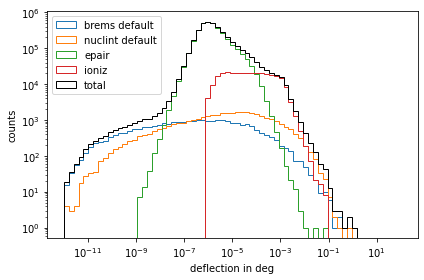

In [16]:
bins = np.logspace(-12, 2, 70)

plt.hist(np.rad2deg(brems_defl_default_ex), bins=bins, histtype='step', color=colors['brems'], label='brems default')
plt.hist(np.rad2deg(nuclint_defl_default_ex), bins=bins, histtype='step', color=colors['nuclint'], label='nuclint default')
plt.hist(np.rad2deg(epair_defl_default_ex), bins=bins, histtype='step', color=colors['epair'], label='epair')
plt.hist(np.rad2deg(ioniz_defl_default_ex), bins=bins, histtype='step', color=colors['ioniz'], label='ioniz')

total_defl_default = list(flatten([brems_defl_default_ex, nuclint_defl_default_ex, epair_defl_default_ex, ioniz_defl_default_ex]))
plt.hist(np.rad2deg(total_defl_default), bins=bins, histtype='step', color='black', label='total')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('deflection in deg')
plt.ylabel('counts')
plt.legend(loc='upper left')
plt.tight_layout()
if save_plot:
    plt.savefig(plot_dir + set_name + '_default.pdf')
# ratio of zeros
print('ratio of zeros: ', np.sum(np.array(stoch_defl)==0)/len(stoch_defl)) # angle calculated in propagation
print('ratio of zeros (extern): ', np.sum(np.array(total_defl_default)==0)/len(total_defl_default))

## Plots brems nuclint tracks

ratio of zeros:  0.22344701898303332
ratio of zeros (extern):  5.600985773496135e-05


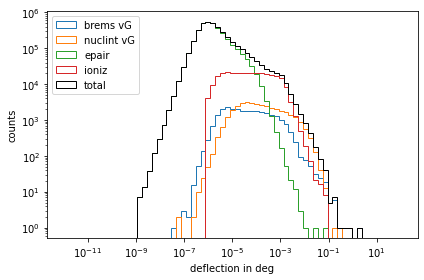

In [17]:
bins = np.logspace(-12, 2, 70)

plt.hist(np.rad2deg(brems_defl_vG_ex), bins=bins, histtype='step', color=colors['brems'], label='brems vG')
plt.hist(np.rad2deg(nuclint_defl_vG_ex), bins=bins, histtype='step', color=colors['nuclint'], label='nuclint vG')
plt.hist(np.rad2deg(epair_defl_default_ex), bins=bins, histtype='step', color=colors['epair'], label='epair')
plt.hist(np.rad2deg(ioniz_defl_default_ex), bins=bins, histtype='step', color=colors['ioniz'], label='ioniz')

total_defl_vG = list(flatten([brems_defl_vG_ex, nuclint_defl_vG_ex, epair_defl_default_ex, ioniz_defl_default_ex]))
plt.hist(np.rad2deg(total_defl_vG), bins=bins, histtype='step', color='black', label='total')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('deflection in deg')
plt.ylabel('counts')
plt.legend(loc='upper left')
plt.tight_layout()
if save_plot:
    plt.savefig(plot_dir + set_name + '_vG.pdf')

# ratio of zeros
print('ratio of zeros: ', np.sum(np.array(stoch_defl_vG)==0)/len(stoch_defl_vG)) # angle calculated in propagation
print('ratio of zeros (extern): ', np.sum(np.array(total_defl_vG)==0)/len(total_defl_vG))

median brems:  3.80719731044687e-05 , low 95%: 1.4395657429725528e-06, high 95: 0.0029744293880631266
median nuclint:  0.00011689564792964204 , low 95%: 4.180084824142579e-06, high 95: 0.009631607730537018
median epair:  1.2562030154574238e-06 , low 95%: 1.558575234278001e-07, high 95: 4.238512932908016e-05
median ioniz:  4.430583459678831e-05 , low 95%: 1.4787793334710982e-06, high 95: 0.0018148395157161227
median total:  1.4731194585379392e-06 , low 95%: 1.642061301897989e-07, high 95: 0.000279064109138651
[nan nan nan nan nan] [3.80719731e-05 1.16895648e-04 1.25620302e-06 4.43058346e-05
 1.47311946e-06] [1.43956574e-06 4.18008482e-06 1.55857523e-07 1.47877933e-06
 1.64206130e-07] [2.97442939e-03 9.63160773e-03 4.23851293e-05 1.81483952e-03
 2.79064109e-04]
ratio of zeros:  0.22344701898303332
ratio of zeros (extern):  5.600985773496135e-05


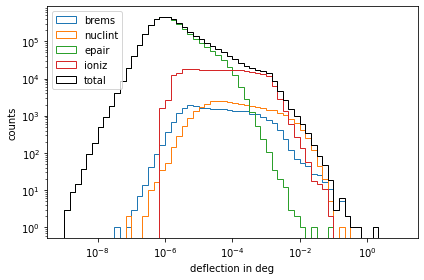

In [18]:
bins = np.logspace(-9, 1, 61)

plt.hist(np.rad2deg(brems_defl_vG_ex), bins=bins, histtype='step', color=colors['brems'], label='brems')
plt.hist(np.rad2deg(nuclint_defl_vG_ex), bins=bins, histtype='step', color=colors['nuclint'], label='nuclint')
plt.hist(np.rad2deg(epair_defl_default_ex), bins=bins, histtype='step', color=colors['epair'], label='epair')
plt.hist(np.rad2deg(ioniz_defl_default_ex), bins=bins, histtype='step', color=colors['ioniz'], label='ioniz')



total_defl_vG = list(flatten([brems_defl_vG_ex, nuclint_defl_vG_ex, epair_defl_default_ex, ioniz_defl_default_ex]))
plt.hist(np.rad2deg(total_defl_vG), bins=bins, histtype='step', color='black', label='total')

print('median brems: ', np.median(np.rad2deg(brems_defl_vG_ex)), ', low 95%: {}, high 95: {}'.format(np.quantile(np.rad2deg(brems_defl_vG_ex), 0.025), np.quantile(np.rad2deg(brems_defl_vG_ex), 0.975)))
print('median nuclint: ', np.median(np.rad2deg(nuclint_defl_vG_ex)), ', low 95%: {}, high 95: {}'.format(np.quantile(np.rad2deg(nuclint_defl_vG_ex), 0.025), np.quantile(np.rad2deg(nuclint_defl_vG_ex), 0.975)))
print('median epair: ', np.median(np.rad2deg(epair_defl_default_ex)), ', low 95%: {}, high 95: {}'.format(np.quantile(np.rad2deg(epair_defl_default_ex), 0.025), np.quantile(np.rad2deg(epair_defl_default_ex), 0.975)))
print('median ioniz: ', np.median(np.rad2deg(ioniz_defl_default_ex)), ', low 95%: {}, high 95: {}'.format(np.quantile(np.rad2deg(ioniz_defl_default_ex), 0.025), np.quantile(np.rad2deg(ioniz_defl_default_ex), 0.975)))
print('median total: ', np.median(np.rad2deg(total_defl_vG)), ', low 95%: {}, high 95: {}'.format(np.quantile(np.rad2deg(total_defl_vG), 0.025), np.quantile(np.rad2deg(total_defl_vG), 0.975)))

file = '{}_data.txt'.format(set_name)
os.system('touch {}{}'.format(plot_dir, file))
f = open(plot_dir+file, "w")
f.write("typ, median, low95, high95\n")
f.write("brems, {}, {}, {}\n".format(np.median(np.rad2deg(brems_defl_vG_ex)), np.quantile(np.rad2deg(brems_defl_vG_ex), 0.025), np.quantile(np.rad2deg(brems_defl_vG_ex), 0.975)))
f.write("nuclint, {}, {}, {}\n".format(np.median(np.rad2deg(nuclint_defl_vG_ex)), np.quantile(np.rad2deg(nuclint_defl_vG_ex), 0.025), np.quantile(np.rad2deg(nuclint_defl_vG_ex), 0.975)))
f.write("epair, {}, {}, {}\n".format(np.median(np.rad2deg(epair_defl_default_ex)), np.quantile(np.rad2deg(epair_defl_default_ex), 0.025), np.quantile(np.rad2deg(epair_defl_default_ex), 0.975)))
f.write("ioniz, {}, {}, {}\n".format(np.median(np.rad2deg(ioniz_defl_default_ex)), np.quantile(np.rad2deg(ioniz_defl_default_ex), 0.025), np.quantile(np.rad2deg(ioniz_defl_default_ex), 0.975)))
f.write("total, {}, {}, {}\n".format(np.median(np.rad2deg(total_defl_vG)), np.quantile(np.rad2deg(total_defl_vG), 0.025), np.quantile(np.rad2deg(total_defl_vG), 0.975)))
f.close()

typ, med, low, high = np.genfromtxt(plot_dir+file, skip_header=1, delimiter=',', unpack=True)
print(typ, med, low, high)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('deflection in deg')
plt.ylabel('counts')
plt.legend(loc='upper left')
# plt.xticks([1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 
#            [r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$',r'$10^{-4}$',r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$'])
plt.tight_layout()
if save_plot:
    plt.savefig(plot_dir + set_name + '_vG_binning.pdf')

# ratio of zeros
print('ratio of zeros: ', np.sum(np.array(stoch_defl_vG)==0)/len(stoch_defl_vG)) # angle calculated in propagation
print('ratio of zeros (extern): ', np.sum(np.array(total_defl_vG)==0)/len(total_defl_vG))

In [40]:
# save deflections of each interaction type for final paper notebook, using van Ginneken
df = pd.DataFrame()
df['brems_defl_vG_ex'] = brems_defl_vG_ex
df.to_hdf(plot_dir + 'FINAL_defl_along_sampling_1PeV_1TeV_1000events.hdf5', key='brems_defl_vG_ex')
df = pd.DataFrame()
df['nuclint_defl_vG_ex'] = nuclint_defl_vG_ex
df.to_hdf(plot_dir + 'FINAL_defl_along_sampling_1PeV_1TeV_1000events.hdf5', key='nuclint_defl_vG_ex')
df = pd.DataFrame()
df['epair_defl_default_ex'] = epair_defl_default_ex
df.to_hdf(plot_dir + 'FINAL_defl_along_sampling_1PeV_1TeV_1000events.hdf5', key='epair_defl_default_ex')
df = pd.DataFrame()
df['ioniz_defl_default_ex'] = ioniz_defl_default_ex
df.to_hdf(plot_dir + 'FINAL_defl_along_sampling_1PeV_1TeV_1000events.hdf5', key='ioniz_defl_default_ex')
df = pd.DataFrame()
df['cont_moliere'] = df_moliere.cont_moliere
df.to_hdf(plot_dir + 'FINAL_defl_along_sampling_1PeV_1TeV_1000events.hdf5', key='cont_moliere')
df = pd.DataFrame()
df['cont_highland'] = df_highland.cont_highland
df.to_hdf(plot_dir + 'FINAL_defl_along_sampling_1PeV_1TeV_1000events.hdf5', key='cont_highland')

median brems:  3.80719731044687e-05 , low 95%: 1.4395657429725528e-06, high 95: 0.0029744293880631266
median nuclint:  0.00011689564792964204 , low 95%: 4.180084824142579e-06, high 95: 0.009631607730537018
median epair:  1.2562030154574238e-06 , low 95%: 1.558575234278001e-07, high 95: 4.238512932908016e-05
median ioniz:  4.430583459678831e-05 , low 95%: 1.4787793334710982e-06, high 95: 0.0018148395157161227
median total:  1.4731194585379392e-06 , low 95%: 1.642061301897989e-07, high 95: 0.000279064109138651
median total cont:  3.894291349042205e-06 , low 95%: 2.1746180562260397e-07, high 95: 0.001288161326506989
median moliere:  1.2292222912206651e-05 , low 95%: 4.883319844405444e-07, high 95: 0.0022222394944974924
median highland:  1.2499374024179615581e-05 , low 95%: 5.065769225773643e-07, high 95: 0.00224984847717195
[nan nan nan nan nan nan nan nan] [3.80719731e-05 1.16895648e-04 1.25620302e-06 4.43058346e-05
 1.47311946e-06 3.89429135e-06 1.22922229e-05 1.24993740e-05] [1.4395657

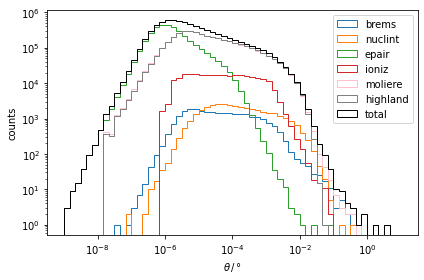

In [25]:
bins = np.logspace(-9, 1, 61)

plt.hist(np.rad2deg(brems_defl_vG_ex), bins=bins, histtype='step', color=colors['brems'], label='brems')
plt.hist(np.rad2deg(nuclint_defl_vG_ex), bins=bins, histtype='step', color=colors['nuclint'], label='nuclint')
plt.hist(np.rad2deg(epair_defl_default_ex), bins=bins, histtype='step', color=colors['epair'], label='epair')
plt.hist(np.rad2deg(ioniz_defl_default_ex), bins=bins, histtype='step', color=colors['ioniz'], label='ioniz')


if scattering_method == "moliere":    
    file = '{}_data_moliere.hdf5'.format(set_name)
    df_moliere = pd.DataFrame()
    df_moliere['cont_moliere'] = cont_defl
    df_moliere.to_hdf(plot_dir+file, key='moliere')
    try:
        set_name_h = "{}_{}_{}events_{}_ecut{}_vcut{}_interpol{}".format(energy_name(E_i), energy_name(E_f), n_events, "highland", e_cut, v_cut, interpol_nodes)
        file = '{}_data_highland.hdf5'.format(set_name_h)
        df_highland = pd.read_hdf(plot_dir+file)
    except:
        print('--- RUN HIGHLAND ---')
elif scattering_method == "highland":
    file = '{}_data_highland.hdf5'.format(set_name)
    df_highland = pd.DataFrame()
    df_highland['cont_highland'] = cont_defl
    df_highland.to_hdf(plot_dir+file, key='highland')
    try:
        set_name_m = "{}_{}_{}events_{}_ecut{}_vcut{}_interpol{}".format(energy_name(E_i), energy_name(E_f), n_events, "moliere", e_cut, v_cut, interpol_nodes)
        file = '{}_data_moliere.hdf5'.format(set_name_m)
        df_moliere = pd.read_hdf(plot_dir+file)
    except:
        print('--- RUN MOLIERE ---')
else:
    print('Error')

plt.hist(np.rad2deg(df_moliere.cont_moliere), bins=bins, histtype='step', color='pink', label='moliere')
plt.hist(np.rad2deg(df_highland.cont_highland), bins=bins, histtype='step', color='gray', label='highland')

# total with moliere
total_defl_vG_cont = list(flatten([brems_defl_vG_ex, nuclint_defl_vG_ex, epair_defl_default_ex, ioniz_defl_default_ex, df_moliere.cont_moliere]))
plt.hist(np.rad2deg(total_defl_vG_cont), bins=bins, histtype='step', color='black', label='total')


print('median brems: ', np.median(np.rad2deg(brems_defl_vG_ex)), ', low 95%: {}, high 95: {}'.format(np.quantile(np.rad2deg(brems_defl_vG_ex), 0.025), np.quantile(np.rad2deg(brems_defl_vG_ex), 0.975)))
print('median nuclint: ', np.median(np.rad2deg(nuclint_defl_vG_ex)), ', low 95%: {}, high 95: {}'.format(np.quantile(np.rad2deg(nuclint_defl_vG_ex), 0.025), np.quantile(np.rad2deg(nuclint_defl_vG_ex), 0.975)))
print('median epair: ', np.median(np.rad2deg(epair_defl_default_ex)), ', low 95%: {}, high 95: {}'.format(np.quantile(np.rad2deg(epair_defl_default_ex), 0.025), np.quantile(np.rad2deg(epair_defl_default_ex), 0.975)))
print('median ioniz: ', np.median(np.rad2deg(ioniz_defl_default_ex)), ', low 95%: {}, high 95: {}'.format(np.quantile(np.rad2deg(ioniz_defl_default_ex), 0.025), np.quantile(np.rad2deg(ioniz_defl_default_ex), 0.975)))
print('median total: ', np.median(np.rad2deg(total_defl_vG)), ', low 95%: {}, high 95: {}'.format(np.quantile(np.rad2deg(total_defl_vG), 0.025), np.quantile(np.rad2deg(total_defl_vG), 0.975)))
print('median total cont: ', np.median(np.rad2deg(total_defl_vG_cont)), ', low 95%: {}, high 95: {}'.format(np.quantile(np.rad2deg(total_defl_vG_cont), 0.025), np.quantile(np.rad2deg(total_defl_vG_cont), 0.975)))
print('median moliere: ', np.median(np.rad2deg(df_moliere.cont_moliere)), ', low 95%: {}, high 95: {}'.format(np.quantile(np.rad2deg(df_moliere.cont_moliere), 0.025), np.quantile(np.rad2deg(df_moliere.cont_moliere), 0.975)))
print('median highland: ', np.median(np.rad2deg(df_highland.cont_highland)), ', low 95%: {}, high 95: {}'.format(np.quantile(np.rad2deg(df_highland.cont_highland), 0.025), np.quantile(np.rad2deg(df_highland.cont_highland), 0.975)))



file = '{}_data.txt'.format(set_name)
os.system('touch {}{}'.format(plot_dir, file))
f = open(plot_dir+file, "w")
f.write("typ, median, low95, high95\n")
f.write("brems, {}, {}, {}\n".format(np.median(np.rad2deg(brems_defl_vG_ex)), np.quantile(np.rad2deg(brems_defl_vG_ex), 0.025), np.quantile(np.rad2deg(brems_defl_vG_ex), 0.975)))
f.write("nuclint, {}, {}, {}\n".format(np.median(np.rad2deg(nuclint_defl_vG_ex)), np.quantile(np.rad2deg(nuclint_defl_vG_ex), 0.025), np.quantile(np.rad2deg(nuclint_defl_vG_ex), 0.975)))
f.write("epair, {}, {}, {}\n".format(np.median(np.rad2deg(epair_defl_default_ex)), np.quantile(np.rad2deg(epair_defl_default_ex), 0.025), np.quantile(np.rad2deg(epair_defl_default_ex), 0.975)))
f.write("ioniz, {}, {}, {}\n".format(np.median(np.rad2deg(ioniz_defl_default_ex)), np.quantile(np.rad2deg(ioniz_defl_default_ex), 0.025), np.quantile(np.rad2deg(ioniz_defl_default_ex), 0.975)))
f.write("total, {}, {}, {}\n".format(np.median(np.rad2deg(total_defl_vG)), np.quantile(np.rad2deg(total_defl_vG), 0.025), np.quantile(np.rad2deg(total_defl_vG), 0.975)))
f.write("total cont, {}, {}, {}\n".format(np.median(np.rad2deg(total_defl_vG_cont)), np.quantile(np.rad2deg(total_defl_vG), 0.025), np.quantile(np.rad2deg(total_defl_vG), 0.975)))
f.write("moliere, {}, {}, {}\n".format(np.median(np.rad2deg(df_moliere.cont_moliere)), np.quantile(np.rad2deg(df_moliere.cont_moliere), 0.025), np.quantile(np.rad2deg(df_moliere.cont_moliere), 0.975)))
f.write("highland, {}, {}, {}\n".format(np.median(np.rad2deg(df_highland.cont_highland)), np.quantile(np.rad2deg(df_highland.cont_highland), 0.025), np.quantile(np.rad2deg(df_highland.cont_highland), 0.975)))
f.close()

typ, med, low, high = np.genfromtxt(plot_dir+file, skip_header=1, delimiter=',', unpack=True)
print(typ, med, low, high)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta\,/\,$°')
plt.ylabel('counts')
plt.legend(loc='upper right')
# plt.xticks([1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 
#            [r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$',r'$10^{-4}$',r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$'])
plt.tight_layout()
if save_plot:
    plt.savefig(plot_dir + set_name + '_vG_binning_paper.pdf')

# ratio of zeros
print('ratio of zeros: ', np.sum(np.array(stoch_defl_vG)==0)/len(stoch_defl_vG)) # angle calculated in propagation
print('ratio of zeros (extern): ', np.sum(np.array(total_defl_vG)==0)/len(total_defl_vG))

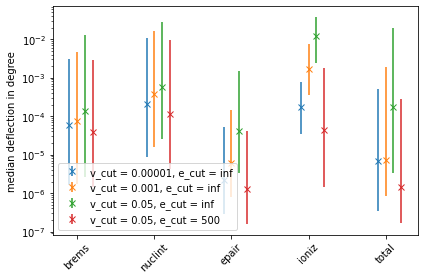

In [20]:
typ, med_00001, low_00001, high_00001 = np.genfromtxt('plots/deflection_along_sampling/1PeV_1TeV_1000events_moliere_ecutinf_vcut1e-05_interpol200_data.txt', skip_header=1, delimiter=',', unpack=True)
typ, med_001, low_001, high_001 = np.genfromtxt('plots/deflection_along_sampling/1PeV_1TeV_1000events_moliere_ecutinf_vcut0.001_interpol200_data.txt', skip_header=1, delimiter=',', unpack=True)
typ, med_05, low_05, high_05 = np.genfromtxt('plots/deflection_along_sampling/1PeV_1TeV_1000events_moliere_ecutinf_vcut0.05_interpol200_data.txt', skip_header=1, delimiter=',', unpack=True)
typ, med_05_500, low_05_500, high_05_500 = np.genfromtxt('plots/deflection_along_sampling/1PeV_1TeV_1000events_moliere_ecut500_vcut0.05_interpol200_data.txt', skip_header=1, delimiter=',', unpack=True)
plt.errorbar(np.arange(len(typ))-0.1, med_00001, yerr=np.array([med_00001-low_00001, high_00001-med_00001]), fmt='x', label='v_cut = 0.00001, e_cut = inf')
plt.errorbar(np.arange(len(typ)), med_001, yerr=np.array([med_001-low_001, high_001-med_001]), fmt='x', label='v_cut = 0.001, e_cut = inf')
plt.errorbar(np.arange(len(typ))+0.1, med_05, yerr=np.array([med_05-low_05, high_05-med_05]), fmt='x', label='v_cut = 0.05, e_cut = inf')
plt.errorbar(np.arange(len(typ))+0.2, med_05_500, yerr=np.array([med_05_500-low_05_500, high_05_500-med_05_500]), fmt='x', label='v_cut = 0.05, e_cut = 500')
plt.yscale('log')
plt.ylabel('median deflection in degree')

# plt.hlines(high_05_500[-1], 0, 4.3, color='black')
# plt.hlines(med_05_500[-1], 0, 4.3, color='black')
# plt.hlines(low_05_500[-1], 0, 4.3, color='black')

plt.xticks([0, 1, 2, 3, 4], ['brems', 'nuclint', 'epair', 'ioniz', 'total'], rotation=45)
plt.legend(loc='lower left')
plt.tight_layout()
if save_plot:
    plt.savefig(plot_dir + set_name + '_check_different_cuts.pdf')

In [21]:
prop_dist = []
for track in tracks_brems_nuclint:
    prop_dist.append(track.track_propagated_distances()[-1]/100)
print('prop dist: ', np.median(prop_dist), 'low 95%: {}, high 95: {}'.format(np.quantile(prop_dist, 0.025), np.quantile(prop_dist, 0.975)))

prop dist:  16365.082305150056 low 95%: 7325.565518100324, high 95: 24628.057113585222


# Comparison

## brems

In [ ]:
bins = np.logspace(-15, 2, 100)

n_0 = plt.hist(brems_defl, bins=bins, histtype='step', label='brems default proposal')
n_00 = plt.hist(brems_defl_vG, bins=bins, histtype='step', label='brems vG proposal')

n_1 = plt.hist(brems_defl_default_ex, bins=bins, histtype='step', label='brems default python')
n_2 = plt.hist(brems_defl_vG_ex, bins=bins, histtype='step', label='brems vG python')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('deflection in rad')
plt.legend(loc='best')
plt.tight_layout()
if save_plot:
    plt.savefig(plot_dir + set_name + '_compare_brems.pdf')
print(np.sum(n_0[0]))
print(np.sum(n_00[0]))
print(np.sum(n_1[0]))
print(np.sum(n_2[0]))

## epair 

In [ ]:
bins = np.logspace(-15, 2, 100)

n_0 = plt.hist(epair_defl, bins=bins, histtype='step', label='epair default proposal')
# n_00 = plt.hist(epair_defl_vG, bins=bins, histtype='step', label='epair vG proposal')

n_1 = plt.hist(epair_defl_default_ex, bins=bins, histtype='step', label='epair default python')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('deflection in rad')
plt.legend(loc='best')
plt.tight_layout
if save_plot:
    plt.savefig(plot_dir + set_name + '_compare_epair.pdf')
print(np.sum(n_0[0]))
# print(np.sum(n_00[0]))
print(np.sum(n_1[0]))

## nuclint

In [ ]:
bins = np.logspace(-15, 2, 100)

n_0 = plt.hist(nuclint_defl, bins=bins, histtype='step', label='nuclint default proposal')
n_00 = plt.hist(nuclint_defl_vG, bins=bins, histtype='step', label='nuclint vG proposal')


n_1 = plt.hist(nuclint_defl_default_ex, bins=bins, histtype='step', label='nuclint default python')
n_2 = plt.hist(nuclint_defl_vG_ex, bins=bins, histtype='step', label='nuclint vG python')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('deflection in rad')
plt.legend(loc='upper left')
plt.tight_layout()
if save_plot:
    plt.savefig(plot_dir + set_name + '_compare_nuclint.pdf')
print(np.sum(n_0[0]))
print(np.sum(n_00[0]))
print(np.sum(n_1[0]))
print(np.sum(n_2[0]))

## ioniz

In [ ]:
bins = np.logspace(-15, 2, 100)

n_0 = plt.hist(ioniz_defl, bins=bins, histtype='step', label='ioniz default proposal')
# n_00 = plt.hist(ioniz_defl_vG, bins=bins, histtype='step', label='ioniz vG proposal')

n_1 = plt.hist(ioniz_defl_default_ex, bins=bins, histtype='step', label='ioniz default python')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('deflection in rad')
plt.legend(loc='upper left')
plt.tight_layout()
if save_plot:
    plt.savefig(plot_dir + set_name + '_compare_ioniz.pdf')
print(np.sum(n_0[0]))
# print(np.sum(n_00[0]))
print(np.sum(n_1[0]))

# Check brems vG different Z

In [ ]:
bins = np.logspace(-15, 2, 100)

plt.hist(brems_defl_vG, bins=bins, histtype='step', label='brems vG Ice proposal')
plt.hist(brems_defl_vG_ex, bins=bins, histtype='step', label='brems vG Z=1 python')
plt.hist(brems_defl_vG_ex_Z8, bins=bins, histtype='step', label='brems vG Z=8 python')
plt.hist(brems_defl_vG_ex_Z82, bins=bins, histtype='step', label='brems vG Z=82 python')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('deflection in rad')
plt.legend(loc='lower left')
plt.tight_layout()
if save_plot:
    plt.savefig(plot_dir + set_name + '_compare_brems_differentZ.pdf')